In [27]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from torchvision.transforms import ToTensor, Normalize, Resize
import pandas as pd

In [28]:

dataset_path = '/kaggle/input/german-traffic-sign-benchmark'

print(os.listdir(dataset_path))

train_csv_path = os.path.join(dataset_path, 'Train.csv')
test_csv_path = os.path.join(dataset_path, 'Test.csv')

train_folder_path = os.path.join(dataset_path, 'Train')
test_folder_path = os.path.join(dataset_path, 'Test')


print(train_csv_path)
print(test_csv_path)
print(train_folder_path)
print(test_folder_path)

['Meta', 'Meta.csv', 'Train.csv', 'Test.csv', 'Test', 'Train']
/kaggle/input/german-traffic-sign-benchmark/Train.csv
/kaggle/input/german-traffic-sign-benchmark/Test.csv
/kaggle/input/german-traffic-sign-benchmark/Train
/kaggle/input/german-traffic-sign-benchmark/Test


In [29]:
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

In [30]:
train_file_paths = train_df['Path'].values
train_labels = train_df['ClassId'].values
test_file_paths = test_df['Path'].values
test_labels = test_df['ClassId'].values

In [31]:
class TrafficSignClassifier(nn.Module):
    def __init__(self, num_classes):
        super(TrafficSignClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256), #2048
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
learning_rate = 0.001
num_epochs = 3


transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


class TrafficSignDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 7])
        image = Image.open(img_name).convert("RGB")
        label = self.data_frame.iloc[idx, 6]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [32]:
train_dataset = TrafficSignDataset(train_csv_path, '/kaggle/input/german-traffic-sign-benchmark', transform=transform)
test_dataset = TrafficSignDataset(test_csv_path, '/kaggle/input/german-traffic-sign-benchmark', transform=transform)

In [33]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [34]:
classes = { 1:'Speed limit (20km/h)',
            2:'Speed limit (30km/h)',
            3:'Speed limit (50km/h)',
            4:'Speed limit (60km/h)',
            5:'Speed limit (70km/h)',
            6:'Speed limit (80km/h)',
            7:'End of speed limit (80km/h)',
            8:'Speed limit (100km/h)',
            9:'Speed limit (120km/h)',
            10:'No passing',
            11:'No passing veh over 3.5 tons',
            12:'Right-of-way at intersection',
            13:'Priority road',
            14:'Yield',
            15:'Stop',
            16:'No vehicles',
            17:'Veh > 3.5 tons prohibited',
            18:'No entry',
            19:'General caution',
            20:'Dangerous curve left',
            21:'Dangerous curve right',
            22:'Double curve',
            23:'Bumpy road',
            24:'Slippery road',
            25:'Road narrows on the right',
            26:'Road work',
            27:'Traffic signals',
            28:'Pedestrians',
            29:'Children crossing',
            30:'Bicycles crossing',
            31:'Beware of ice/snow',
            32:'Wild animals crossing',
            33:'End speed + passing limits',
            34:'Turn right ahead',
            35:'Turn left ahead',
            36:'Ahead only',
            37:'Go straight or right',
            38:'Go straight or left',
            39:'Keep right',
            40:'Keep left',
            41:'Roundabout mandatory',
            42:'End of no passing',
            43:'End no passing veh > 3.5 tons' }

num_classes = len(set(classes.values()))

print(f"Number of unique classes: {num_classes}")

Number of unique classes: 43


In [35]:
model = TrafficSignClassifier(num_classes=num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [36]:
total_step = len(train_loader)
print(f"Total Step: {total_step}")

Total Step: 613


In [37]:
# Training loop
for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backwpropagation y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Step [{i+1}/{total_step}], Loss: {loss.item()}')

Epoch [1/3]
Step [100/613], Loss: 2.3609068393707275
Step [200/613], Loss: 1.5724310874938965
Step [300/613], Loss: 1.0304596424102783
Step [400/613], Loss: 0.6175600290298462
Step [500/613], Loss: 0.5029511451721191
Step [600/613], Loss: 0.41616493463516235
Epoch [2/3]
Step [100/613], Loss: 0.18340064585208893
Step [200/613], Loss: 0.16880826652050018
Step [300/613], Loss: 0.06894297897815704
Step [400/613], Loss: 0.08908671140670776
Step [500/613], Loss: 0.17366793751716614
Step [600/613], Loss: 0.19312170147895813
Epoch [3/3]
Step [100/613], Loss: 0.040513813495635986
Step [200/613], Loss: 0.1790020614862442
Step [300/613], Loss: 0.09640222042798996
Step [400/613], Loss: 0.07122931629419327
Step [500/613], Loss: 0.06419823318719864
Step [600/613], Loss: 0.010442398488521576


In [38]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy}%')

Accuracy: 90.40380047505938%


Accuracy: 90.40380047505938%


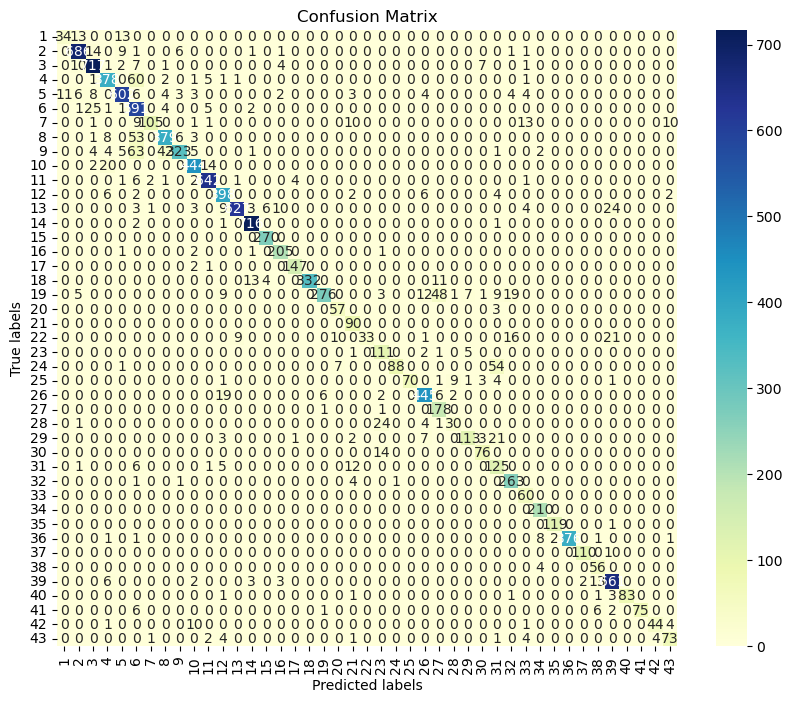

Accuracy for 1: 56.67%
Accuracy for 2: 95.28%
Accuracy for 3: 95.60%
Accuracy for 4: 84.00%
Accuracy for 5: 91.21%
Accuracy for 6: 93.81%
Accuracy for 7: 70.00%
Accuracy for 8: 84.22%
Accuracy for 9: 71.78%
Accuracy for 10: 92.50%
Accuracy for 11: 97.27%
Accuracy for 12: 94.76%
Accuracy for 13: 90.87%
Accuracy for 14: 99.44%
Accuracy for 15: 100.00%
Accuracy for 16: 97.62%
Accuracy for 17: 98.00%
Accuracy for 18: 92.22%
Accuracy for 19: 70.77%
Accuracy for 20: 95.00%
Accuracy for 21: 100.00%
Accuracy for 22: 36.67%
Accuracy for 23: 92.50%
Accuracy for 24: 58.67%
Accuracy for 25: 77.78%
Accuracy for 26: 92.71%
Accuracy for 27: 98.89%
Accuracy for 28: 50.00%
Accuracy for 29: 75.33%
Accuracy for 30: 84.44%
Accuracy for 31: 83.33%
Accuracy for 32: 97.41%
Accuracy for 33: 100.00%
Accuracy for 34: 100.00%
Accuracy for 35: 99.17%
Accuracy for 36: 96.41%
Accuracy for 37: 91.67%
Accuracy for 38: 93.33%
Accuracy for 39: 95.80%
Accuracy for 40: 92.22%
Accuracy for 41: 83.33%
Accuracy for 42: 73.3

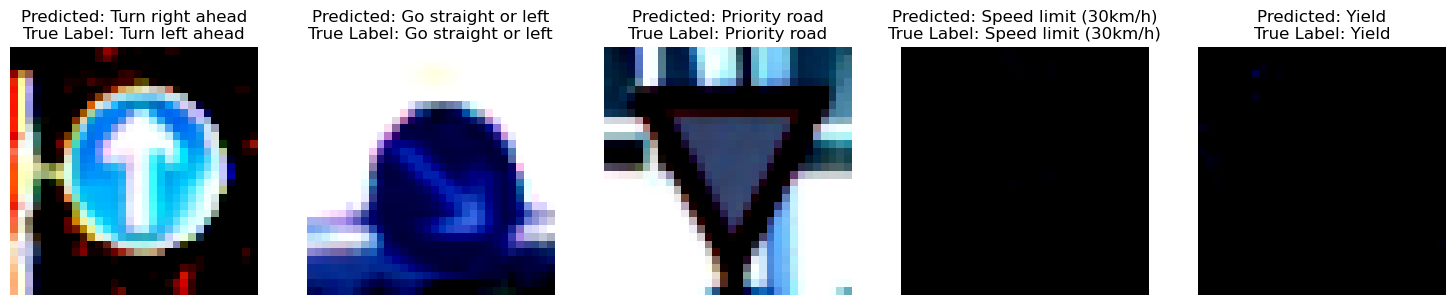

TrafficSignClassifier(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=2048, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=43, bias=True)
  )
)


In [39]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

num_classes = len(classes)
confusion_matrix = np.zeros((num_classes, num_classes))

model.eval()
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        for i in range(len(labels)):
            true_label = labels[i]
            predicted_label = predicted[i]
            confusion_matrix[true_label][predicted_label] += 1

    correct = sum(np.array(predicted_labels) == np.array(true_labels))
    accuracy = 100 * correct / len(true_labels)
    print(f'Accuracy: {accuracy}%')

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap="YlGnBu", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

class_accuracy = confusion_matrix.diagonal() / confusion_matrix.sum(axis=1)
for i, class_name in enumerate(classes):
    print(f"Accuracy for {class_name}: {class_accuracy[i]*100:.2f}%")

num_samples = 5
samples_indices = np.random.choice(len(test_dataset), num_samples, replace=False)

fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

for i, idx in enumerate(samples_indices):
    image, label = test_dataset[idx]
    image = image.permute(1, 2, 0).numpy()  
    predicted = classes[predicted_labels[idx]]
    true_label = classes[true_labels[idx]]

    axes[i].imshow(image)
    axes[i].set_title(f"Predicted: {predicted}\nTrue Label: {true_label}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

print(model)

In [40]:
from torchviz import make_dot

# Crear una instancia del modelo TrafficSignClassifier
model = TrafficSignClassifier(num_classes)

# Crear un tensor de ejemplo para la entrada
example_input = torch.randn(1, 3, 32, 32)  # Tamaño de la entrada: 1 muestra, 3 canales de color, 32x32 píxeles

# Generar el gráfico computacional del modelo
output = model(example_input)
dot = make_dot(output, params=dict(model.named_parameters()))

# Guardar la visualización en formato PNG
dot.render('traffic_sign_classifier', format='png')

'traffic_sign_classifier.png'

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7e279442-4903-409f-9982-72990b288f40' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>